<a href="https://colab.research.google.com/github/Matheus-Homem/russian_weekly_sales/blob/main/notebook/Russian_Weekly_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

## 0.1. Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib import cm
import seaborn as sns
!pip install joypy
from joypy import joyplot
from tabulate import tabulate
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
!pip install boruta
from boruta import BorutaPy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Colors
viridis = cm.get_cmap('viridis', 12)(0.2)

## 0.2. Loading Data

In [4]:
# Importing data from .csv
item_categories = pd.read_csv("https://github.com/Matheus-Homem/future-sales-prediction/raw/main/data/item_categories%20(translated).csv")
items = pd.read_csv("https://github.com/Matheus-Homem/future-sales-prediction/raw/main/data/items%20(translated).csv")
sales_train = pd.read_csv("https://github.com/Matheus-Homem/future-sales-prediction/raw/main/data/sales_train.csv")
shops = pd.read_csv("https://github.com/Matheus-Homem/future-sales-prediction/raw/main/data/shops%20(translated).csv")
holidays = pd.read_csv("https://github.com/Matheus-Homem/russian_weekly_sales/raw/main/data/russian_holidays.csv")

In [5]:
# First row of 'item_categories'
item_categories.loc[0]

item_category_name         PC - Гарнитуры/Наушники
item_category_name_en    PC - Headset / Headphones
item_category_id                                 0
Name: 0, dtype: object

In [6]:
# First row of 'items'
items.loc[0]

item_name                ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D
item_name_en        Lucky In the power of the puffy (reservoir.) D
item_id                                                          0
item_category_id                                                40
Name: 0, dtype: object

In [7]:
# First row of 'sales_train'
sales_train.loc[0]

date              02.01.2013
date_block_num             0
shop_id                   59
item_id                22154
item_price               999
item_cnt_day               1
Name: 0, dtype: object

In [8]:
# First row of 'shops'
shops.loc[0]

shop_name          !Якутск Орджоникидзе, 56 фран
shop_name_en    ! Yakutsk Ordzhonikidze, 56 fran
shop_id                                        0
Name: 0, dtype: object

In [9]:
# First row of 'holidays'
holidays.loc[0]

Day                       Friday
Date                     jan. 01
Holiday Name      New Year's Day
Type            National Holiday
Comments                     NaN
Name: 0, dtype: object

## 0.3. Helper Functions

In [10]:
# Axes label formatter
def format_number(data_value,indx):
  if data_value >= 1000000000:
    formatter = '{:1.1f}B'.format(data_value*0.000000001)
  elif (data_value < 1000000000) & (data_value >= 10000000):  
    formatter = '{:1.0f}M'.format(data_value*0.000001)
  elif (data_value < 10000000) & (data_value >= 1000000):  
    formatter = '{:1.1f}M'.format(data_value*0.000001)
  else:
    formatter = '{:1.0f}K'.format(data_value*0.001)
  return formatter

In [11]:
def cramer_v(x,y):
  # Creating Confusion Matrix
  cm = pd.crosstab(x,y).values
  # Performing Chi² Test from the confusion matrix
  chi2 = stats.chi2_contingency(cm)[0]
  # Adding all values from confusion matrix
  n = cm.sum()
  # Getting the dimensions of the confusion matrix
  r,k = cm.shape

  # Correcting Values
  chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)

  # Appling Cramér's V
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

# 1. Data Description

## 1.1. Merging Tables

In [12]:
df1 = pd.merge(items,item_categories,on='item_category_id')
df1 = pd.merge(sales_train,df1,on='item_id')
df1 = pd.merge(df1,shops,on='shop_id')

cols_drop = ['item_name','item_category_name','shop_name']
df1 = df1.drop(cols_drop, axis=1)

df1.rename(columns={'item_name_en': 'item_name',
                   'item_category_name_en': 'item_category_name',
                   'shop_name_en': 'shop_name'},
                   inplace=True)

df1.sample().T

,2404465
date,30.12.2013
date_block_num,11
shop_id,52
item_id,13621
item_price,199
item_cnt_day,1
item_name,Angry Birds Mug Birds 300ml
item_category_id,69
item_category_name,Gifts - Souvenirs
shop_name,"Ufa TC ""Central"""


## 1.2. Data Dimensions

In [13]:
print('Number of Rows: {:,}'.format(df1.shape[0]))
print('Number of Columns: ',df1.shape[1])

Number of Rows: 2,935,849
Number of Columns:  10


## 1.3. Data Types

In [14]:
df1.dtypes

date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
item_name              object
item_category_id        int64
item_category_name     object
shop_name              object
dtype: object

## 1.4. Change Data Types

In [15]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.5. NA Checking

In [16]:
df1.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

## 1.6. Fillout NA

- None of the columns have null values;

## 1.7. Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Contacatenate
n = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
n.columns = ['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis']

In [19]:
n

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,date_block_num,0.0,33.0,33.0,14.569911,14.0,9.422986,0.203858,-1.082869
1,shop_id,0.0,59.0,59.0,33.001728,31.0,16.226970,-0.072361,-1.025358
2,item_id,0.0,22169.0,22169.0,10197.227057,9343.0,6324.296277,0.257174,-1.225210
3,item_price,-1.0,307980.0,307981.0,890.853233,399.0,1729.799336,10.750423,445.532826
4,item_cnt_day,-22.0,2169.0,2191.0,1.242641,1.0,2.618834,272.833162,177478.098774
5,item_category_id,0.0,83.0,83.0,40.001383,40.0,17.100756,0.318283,-0.525158


### 1.7.2. Categorical Attributes

In [20]:
# Unique values
cat_attributes.apply(lambda x: x.unique().shape[0])

item_name             21720
item_category_name       84
shop_name                60
dtype: int64

# 2. Feature Engineering

In [21]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

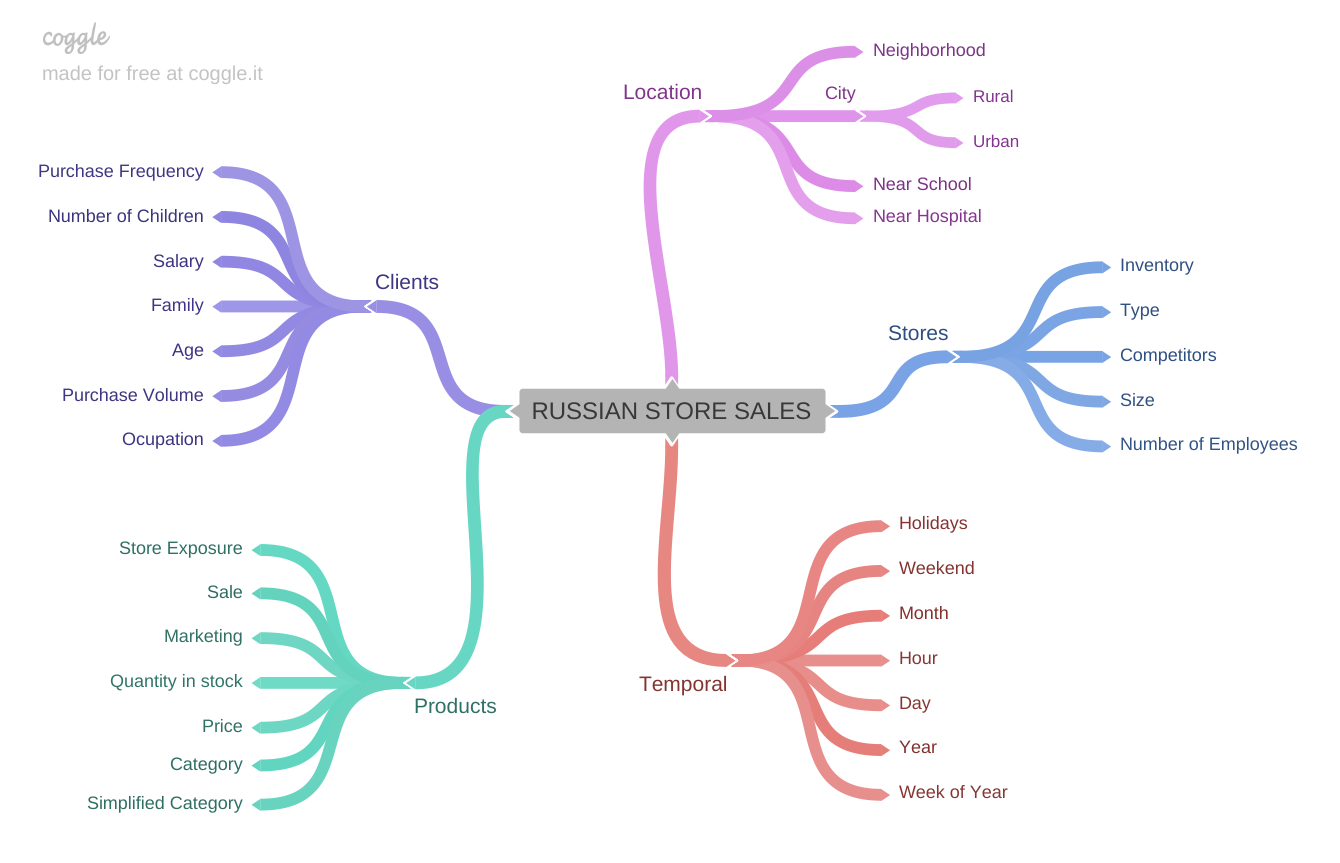

## 2.2. List of Hypothesis

**01.** Stores should sell more over the years

**02.** Stores should sell more in the second semester

**03.** Stores should sell more in the first half of the month

**04.** Stores should sell more on weekends

**05.** Stores located in Moscow should sell more

**06.** Shopping Center type stores should sell more

**07.** Stores should sell less on holidays

**08.** Stores with more item variety should sell more

**09.** Stores with higher range/average prices should sell more

## 2.3. Feature Engineering

### 2.3.1. Main Dataframe

In [22]:
# Studying item_cnt_day
print('Feature item_cnt_day has {} values equal to 0 and {} values less than 0;'.format(df2[df2['item_cnt_day']==0].shape[0],df2[df2['item_cnt_day']<0].shape[0]))
# Since a store cannot sell negative amounts of items, we will assume that such amounts mean 0
df2['item_cnt_day'] = list(map(lambda x: 0 if x<0 else x, df2['item_cnt_day']))
# As seen in 1.7.1. there are high values for the variable, so we will reduce all outliers above the 99.9 percentile to the 99.9 percentile itself
#sub_percentil = np.percentile(df2['item_cnt_day'], 99.9)
#df2['item_cnt_day'] = list(map(lambda x: sub_percentil if x > sub_percentil else x, df2['item_cnt_day']))

Feature item_cnt_day has 0 values equal to 0 and 7356 values less than 0;


In [23]:
# Grouping item categories
unique_categories = list(df2['item_category_name'].unique())
unique_categories.sort()
simple_categories = list(map(lambda x: x.split('-')[0], unique_categories))
simple_categories = list(map(lambda x: x.split('(')[0].rstrip(), simple_categories))
category_dict = dict(zip(unique_categories, simple_categories))
df2['simple_categories'] = df2['item_category_name'].map(category_dict)

# Extracting city name from shop name
unique_shops = df2['shop_name'].unique()
unique_shops.sort()
cities = unique_shops.copy()
cities[:2] = list(map(lambda x: x[2:],cities[:2]))
cities = list(map(lambda x: x.split(' ')[0],cities))
cities[2] = cities[2][3:]
cities = list(map(lambda x: x.capitalize(),cities))
cities_dict = dict(zip(unique_shops, cities))
df2['city'] = df2['shop_name'].map(cities_dict)

# Extracting shop type from shop name
types_list = list(map(lambda x: x.split()[1], unique_shops))
type_dict = {'"Sale"':'None',
             'Yakutsk':'Shopping Center',
             '(Plekhanovskaya,':'None',
             'MTRC':'TRC',
             'Ordzhonikidze,':'None',
             'Posad':'Shopping Center',
             'Store':'None',
             'TC':'TC',
             'TK':'TK',
             'TPC':'TPC',
             'TRC':'TRC',
             'TRK':'TRK',
             'digital':'Digital',
             'shopping':'Shopping Center',
             'st.':'None',
             'store':'None',
             'trade':'None'}
type_list = [*map(type_dict.get,types_list)]
shop_type_dict = dict(zip(unique_shops, type_list))
df2['shop_type'] = df2['shop_name'].map(shop_type_dict)

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# day of week
df2['day_of_week'] = df2['date'].dt.weekday

# Creating the response variable 'sales' which represents the daily sale of each store
daily_sales_df = df2[['date','shop_name','item_cnt_day']].groupby(['shop_name','date']).sum().reset_index()
daily_sales_df['dict'] = daily_sales_df['shop_name'] + daily_sales_df['date'].astype(str)
df2['dict'] = df2['shop_name'] + df2['date'].astype(str)
sales_dict = dict(zip(daily_sales_df['dict'], daily_sales_df['item_cnt_day']))
df2['sales'] = df2['dict'].map(sales_dict)
df2.drop('dict',axis=1,inplace=True)

### 2.3.2. Holidays Dataframe

In [24]:
d = {'jan.':1,
     'Feb':2,
     'mar.':3,
     'May':5,
     'jun.':6,
     'nov.':11,
     'Dec':12}
holidays['Month'] = holidays['Date'].map(lambda x: x.split(' ')[0]).map(d)
holidays['Day'] = holidays['Date'].map(lambda x: x.split(' ')[1]).astype(int)

In [25]:
aux1 = holidays[holidays['Type']=='National Holiday'][['Day','Month']]
aux1 = pd.concat([pd.to_datetime(aux1.assign(Year=2013).loc[:, ['Year','Month','Day']]),
                  pd.to_datetime(aux1.assign(Year=2014).loc[:, ['Year','Month','Day']]),
                  pd.to_datetime(aux1.assign(Year=2015).loc[:, ['Year','Month','Day']])], ignore_index=True)
aux1 = pd.DataFrame({'date':aux1,'holidays':np.ones(63)})
holidays_dict = dict(zip(aux1['date'], aux1['holidays']))
df2['holiday'] = df2['date'].map(holidays_dict)
df2['holiday'].fillna(0,inplace=True)
df2['holiday'] = df2['holiday'].astype(int)

In [26]:
df2.sample().T

,1478676
date,2014-02-01 00:00:00
date_block_num,12
shop_id,28
item_id,19127
item_price,549
item_cnt_day,1
item_name,Passion Don Juan (BD)
item_category_id,40
item_category_name,Cinema - DVD.
shop_name,"Moscow TC ""Mega Teply Stan"" II"


# 3. Feature Filtering

In [27]:
df3 = df2.copy()

## 3.1. Rows Filtering

In [28]:
df3 = df3[df3['sales'] > 0]

## 3.2. Columns Filtering

In [29]:
cols_drop = ['shop_id','item_id','item_category_id','date_block_num','item_cnt_day']
df3.drop(cols_drop,axis=1,inplace=True)
list(df3.columns)

['date',
 'item_price',
 'item_name',
 'item_category_name',
 'shop_name',
 'simple_categories',
 'city',
 'shop_type',
 'year',
 'month',
 'day',
 'week_of_year',
 'year_week',
 'day_of_week',
 'week_tl',
 'sales',
 'holiday']

# 4. Exploratory Data Analysis (EDA)

In [30]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

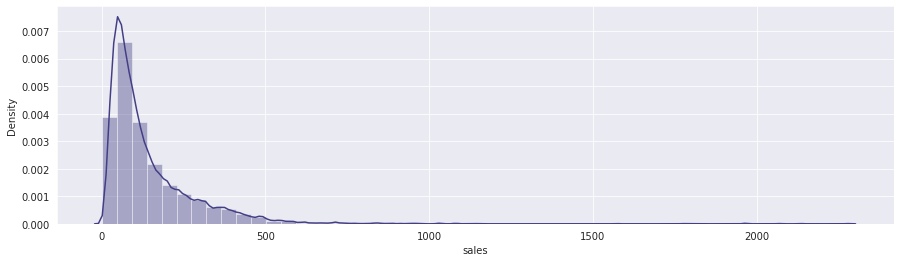

In [31]:
#@title Distribution Plot of Sales Variable
plt.figure(figsize=(15,4))
sns.distplot(df4['sales'],color=viridis)
plt.show()

### 4.1.2. Numerical Variables

In [32]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
cat_attributes = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

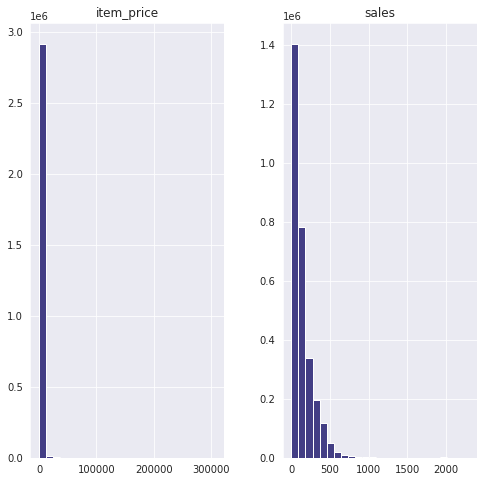

In [33]:
#@title Histograms of all Original Numerical Variables
num_attributes.hist(bins=25,figsize=(8,4),color=viridis);

### 4.1.3. Categorical Variables

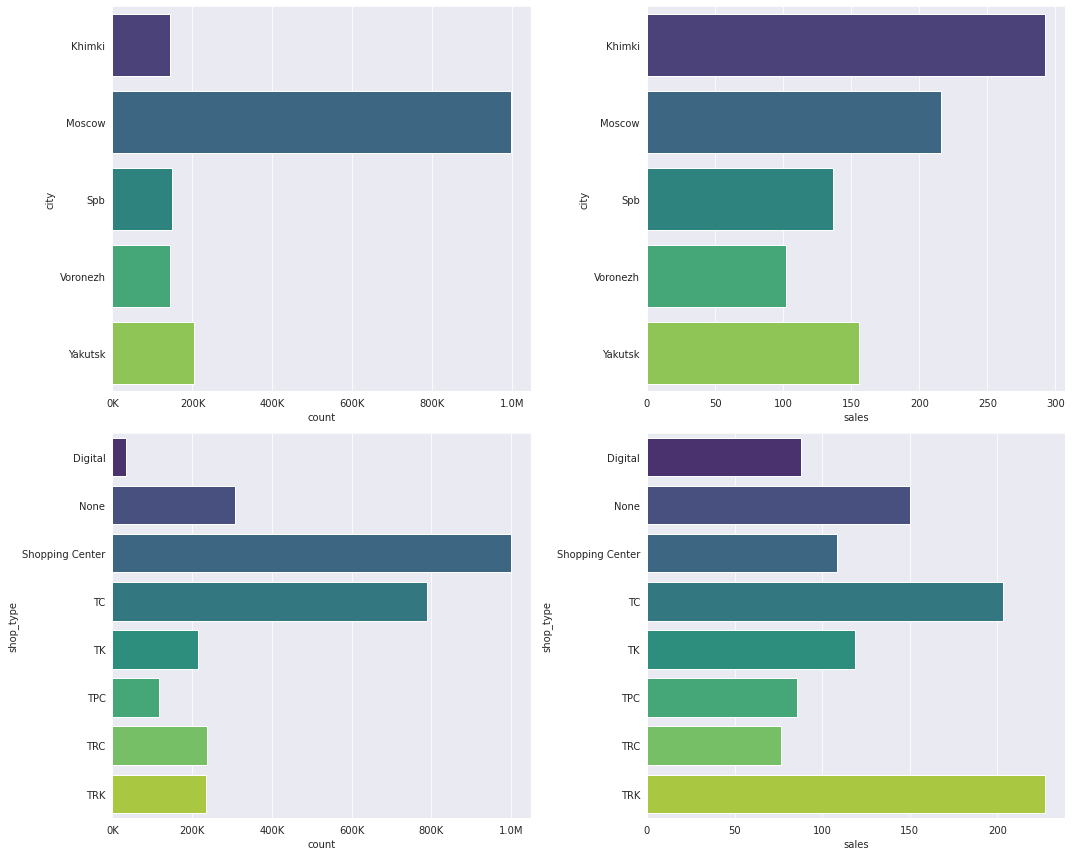

In [34]:
#@title Barplot and countplot for most frequent cities and shop_types
f, axes = plt.subplots(2,2,figsize=(15,12))

# city
aux1 = sorted(list(df4['city'].value_counts().index)[:5])
sns.countplot(y = df4[df4['city'].isin(aux1)]['city'],
              order = aux1,
              palette = 'viridis',
              ax = axes[0,0])
axes[0,0].xaxis.set_major_formatter(tick.FuncFormatter(format_number))

sns.barplot(data = df4[df4['city'].isin(aux1)][['city','sales']].groupby('city').mean().reset_index(),
            y = 'city',
            x = 'sales',
            palette = 'viridis',
            order = aux1,
            ax = axes[0,1])

# shop_type
aux2 = sorted(list(df4['shop_type'].unique()))
sns.countplot(y = df4['shop_type'],
              order = aux2,
              palette = 'viridis',
              ax = axes[1,0])
axes[1,0].xaxis.set_major_formatter(tick.FuncFormatter(format_number))

sns.barplot(data = df4[['shop_type','sales']].groupby('shop_type').mean().reset_index(),
            y = 'shop_type',
            x = 'sales',
            palette = 'viridis',
            order = aux2,
            ax = axes[1,1])

plt.tight_layout()
plt.show()

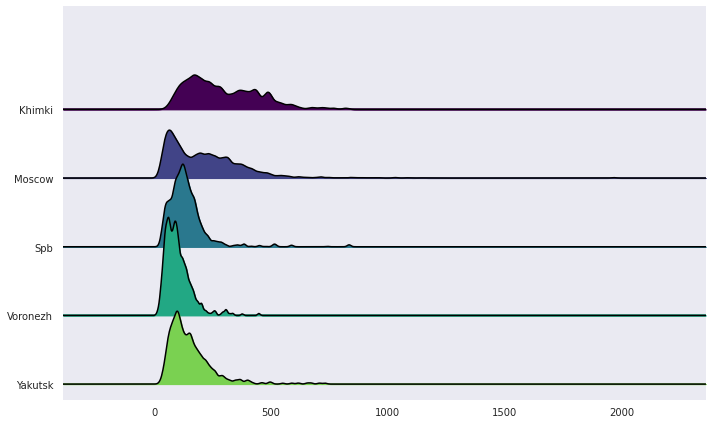

In [35]:
#@title Ridgeline Plot of Sales in different cities
joyplot(
    data=df4[df4['city'].isin(aux1)][['sales','city']],
    by='city',
    colormap=plt.cm.viridis,
    figsize=(10,6))

plt.show()

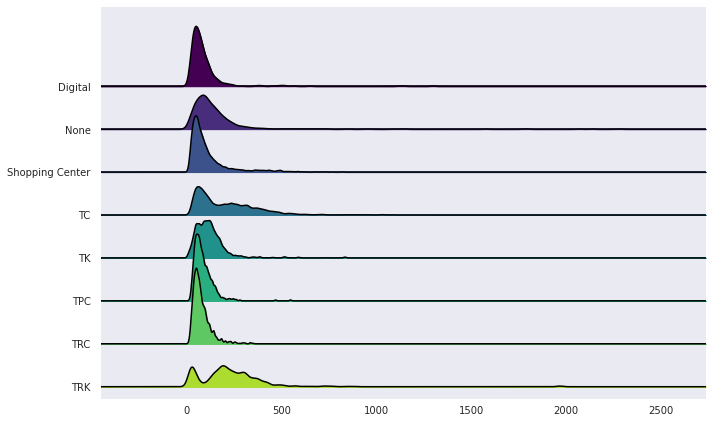

In [36]:
#@title Ridgeline Plot of Sales in different shop types
joyplot(
    data=df4[['sales','shop_type']],
    by='shop_type',
    colormap=plt.cm.viridis,
    figsize=(10,6))

plt.show()

## 4.2. Bivariate Analysis

### $H_{1}:$ Stores should sell more over the years
**FALSE** $\Rightarrow$ Stores sell LESS OVER THE YEARS

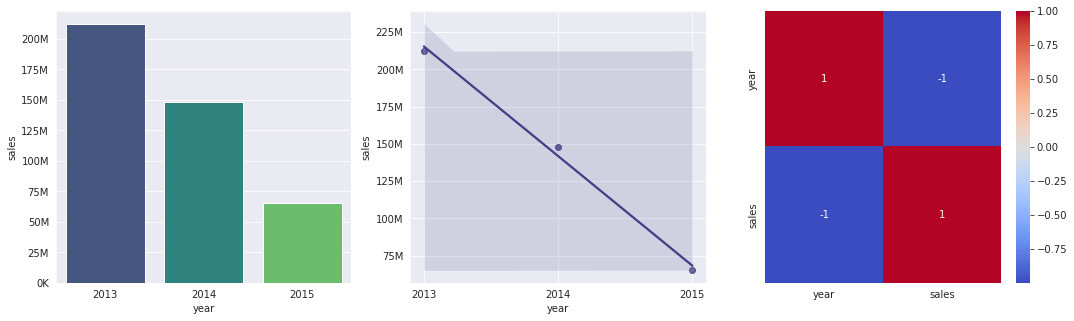

In [37]:
#@title Plot and Correlation of Sales x Years
plt.figure(figsize=(18,5))

aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
g1 = sns.barplot(x='year',y='sales',data=aux1,palette='viridis')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,3,2)
g2 = sns.regplot(x='year',y='sales',data=aux1,color=viridis)
g2.yaxis.set_major_formatter(tick.FuncFormatter(format_number))
g2.set_xticks([2013,2014,2015])

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True,cmap='coolwarm')

plt.show()

### $H_{2}:$ Stores should sell more in the second semester
**FALSE** $\Rightarrow$ Stores sell MORE on the SECOND SEMESTER

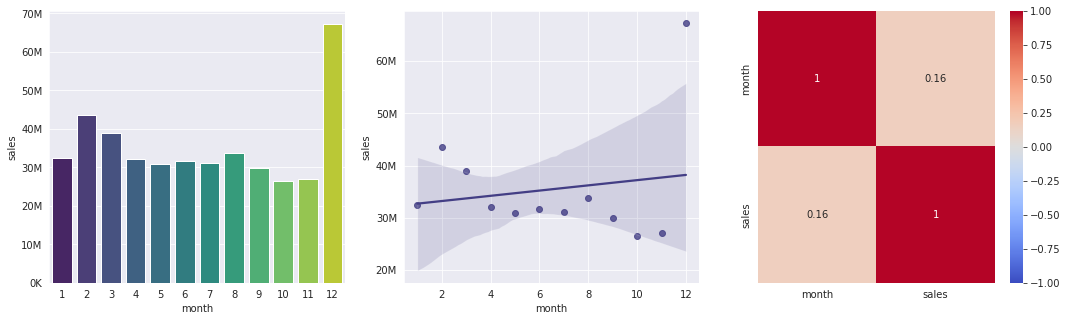

In [38]:
#@title Plot and Correlation of Sales x Months
plt.figure(figsize=(18,5))

aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
g1 = sns.barplot(x='month',y='sales',data=aux1,palette='viridis')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,3,2)
g2 = sns.regplot(x='month',y='sales',data=aux1,color=viridis)
g2.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True,cmap='coolwarm',vmax=1,vmin=-1)

plt.show()

### $H_{3}:$ Stores should sell more in the first half of the month
**FALSE** $\Rightarrow$ Stores sell MORE after the 15th DAY

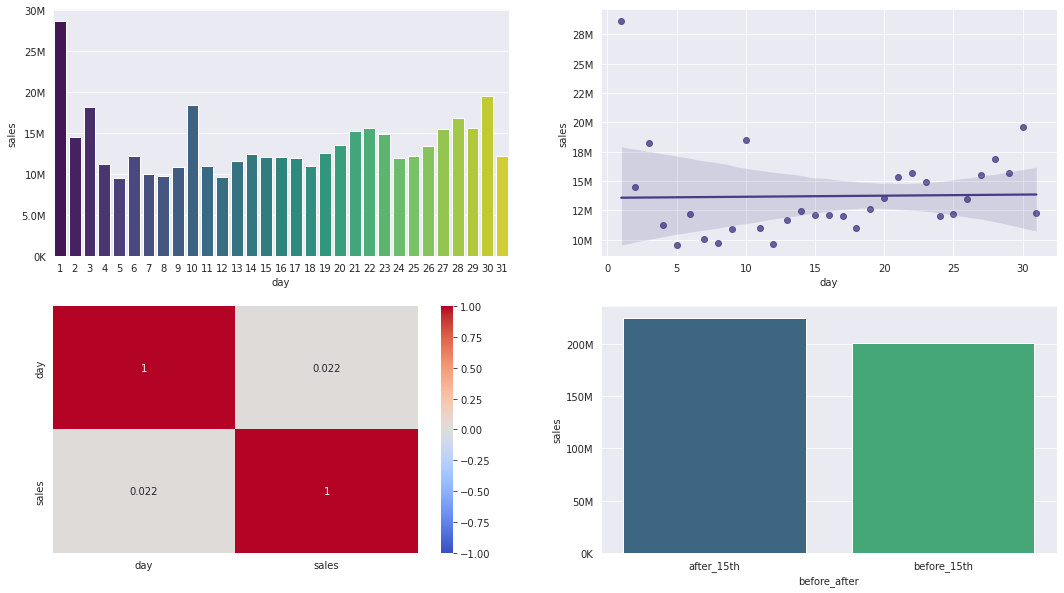

In [39]:
#@title Plot and Correlation of Sales x Days
plt.figure(figsize=(18,10))

aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
g1 = sns.barplot(x='day',y='sales',data=aux1,palette='viridis')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))


plt.subplot(2,2,2)
g2 = sns.regplot(x='day',y='sales',data=aux1,color=viridis)
g2.yaxis.set_major_formatter(tick.FuncFormatter(format_number))


plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True,cmap='coolwarm',vmax=1,vmin=-1)

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_15th' if x <=15 else 'after_15th')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
g4 = sns.barplot(x='before_after',y='sales',data=aux2,palette='viridis')
g4.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

### $H_{4}:$ Stores should sell more on weekends
**TRUE** $\Rightarrow$ Stores sell MORE on weekends

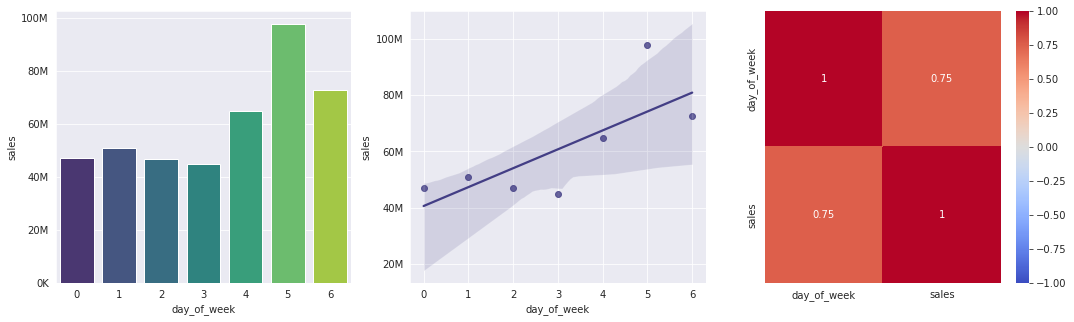

In [40]:
#@title Plot and Correlation of Sales x Day of Week
plt.figure(figsize=(18,5))

aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
g1 = sns.barplot(x='day_of_week',y='sales',data=aux1,palette='viridis')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,3,2)
g2 = sns.regplot(x='day_of_week',y='sales',data=aux1,color=viridis)
g2.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True,cmap='coolwarm',vmax=1,vmin=-1)

plt.show()

### $H_{5}:$ Store located in Moscow should sell more
**TRUE** $\Rightarrow$ Stores located in Moscow SELL MORE

In [41]:
aux1 = df4[df4['city']!='Exit']
aux2 = pd.concat([aux1[['sales','city']].groupby('city').sum().reset_index(),
                 aux1[['sales','city']].groupby('city').mean().reset_index()['sales']],
                 axis=1)
aux2.columns = ['city','total_sales','mean_sales']
aux2.sort_values('mean_sales',ascending=False,inplace=True)

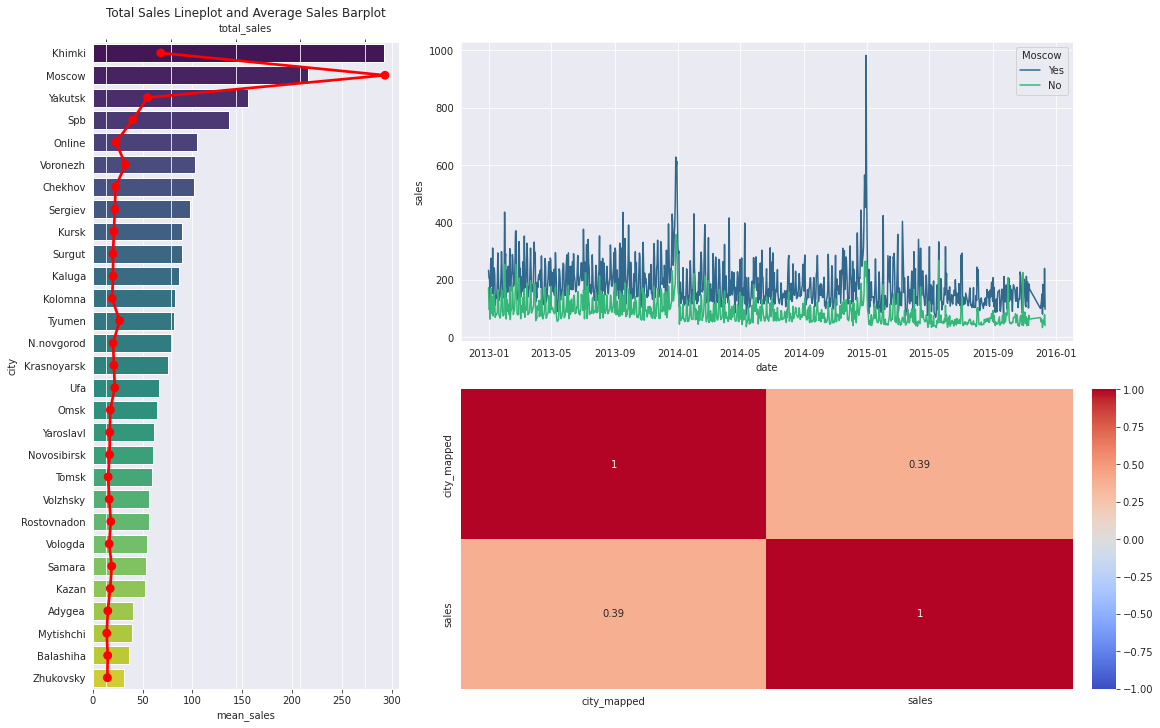

In [42]:
#@title Hypothesis 5 Plots

fig = plt.figure(constrained_layout=True,figsize=(16,10))
spec = fig.add_gridspec(nrows=2,ncols=3)

axes1 = fig.add_subplot(spec[0:, 0])
# Barplot - Average Sales
g1 = sns.barplot(data=aux2,y='city',x='mean_sales',ax=axes1,palette='viridis',label='Average Sales')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

# Lineplot - Total Sales 
axes2 = plt.twiny()
g2 = sns.pointplot(x='total_sales', y='city',ax=axes2 ,data=aux2,color='r',label='Total Sales').set(xticklabels=[])
plt.title('Total Sales Lineplot and Average Sales Barplot')

# Timeline of Sales
axes3 = fig.add_subplot(spec[0, 1:])
aux1['Moscow'] = aux1['city'].map(lambda x: 'Yes' if x=='Moscow' else 'No')
aux3 = aux1[['date','Moscow','sales']].groupby(['date','Moscow']).mean().reset_index()
sns.lineplot(data=aux3,x='date',y='sales',hue='Moscow',palette='viridis',ax=axes3,hue_order=['Yes','No'])

# Correlation Heatmap
axes4 = fig.add_subplot(spec[1:, 1:])
city_dict = dict(zip(aux1['city'].unique(),list(range(29,-1,-1))))
aux1['city_mapped'] = aux1.city.map(city_dict)
g4 = sns.heatmap(aux1[['city_mapped','sales']].corr(method='pearson'),ax=axes4,annot=True,cmap='coolwarm',vmax=1,vmin=-1)

plt.show()

### $H_{6}:$ Shopping Center type stores should sell more
**FALSE** $\Rightarrow$ Stores with 'TC shop type' SELLS MORE than Shopping Center


In [32]:
aux1 = pd.concat([df4[['sales','shop_type']].groupby('shop_type').sum().reset_index(),
                 df4[['sales','shop_type']].groupby('shop_type').mean().reset_index()['sales']],
                 axis=1)
aux1.columns = ['shop_type','total_sales','mean_sales']
aux1.sort_values('mean_sales',ascending=False,inplace=True)

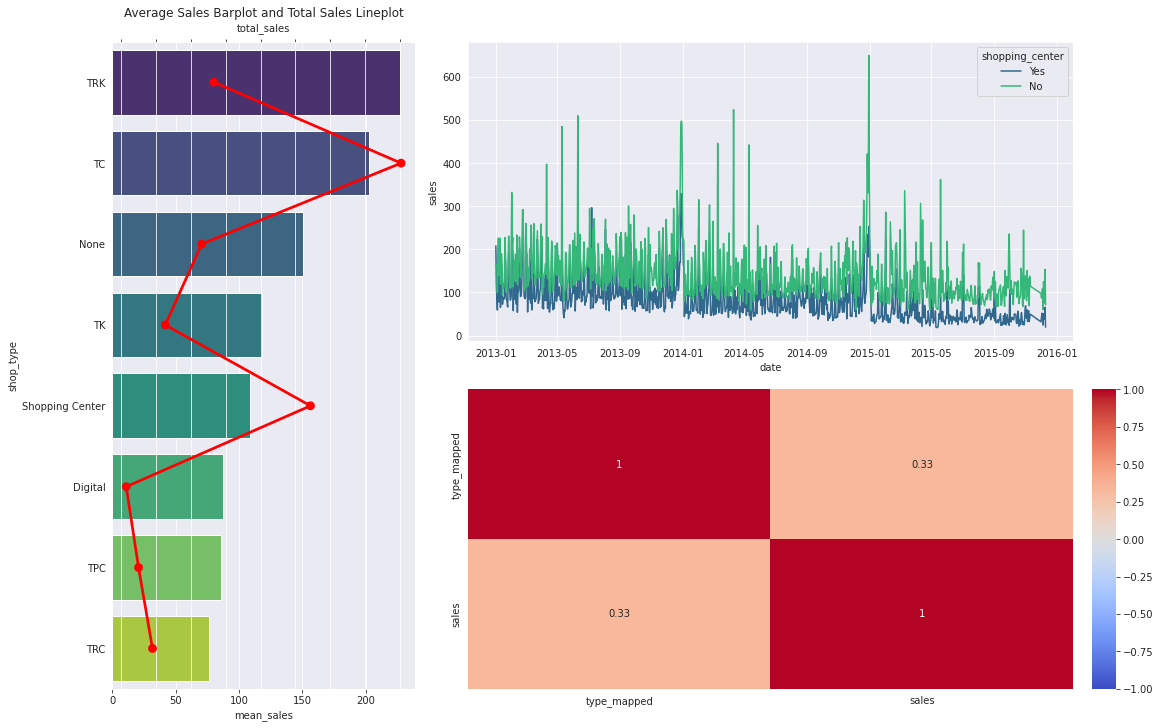

In [50]:
#@title Hypothesis 6 Plots

fig = plt.figure(constrained_layout=True,figsize=(16,10))
spec = fig.add_gridspec(nrows=2,ncols=3)

# Barplot - Average Sales
axes1 = fig.add_subplot(spec[0:, 0])
g1 = sns.barplot(data=aux1,y='shop_type',x='mean_sales',ax=axes1,palette='viridis',label='Average Sales')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

# Lineplot - Total Sales 
axes2 = plt.twiny()
g2 = sns.pointplot(x='total_sales', y='shop_type',ax=axes2 ,data=aux1,color='r',label='Total Sales').set(xticklabels=[])
plt.title('Average Sales Barplot and Total Sales Lineplot')

# Timeline of Sales
axes3 = fig.add_subplot(spec[0, 1:])
df4['shopping_center'] = df4['shop_type'].map(lambda x: 'Yes' if x=='Shopping Center' else 'No')
aux2 = df4[['date','shopping_center','sales']].groupby(['date','shopping_center']).mean().reset_index()
sns.lineplot(data=aux2,x='date',y='sales',hue='shopping_center',palette='viridis',ax=axes3,hue_order=['Yes','No'])

# Correlation Heatmap
axes4 = fig.add_subplot(spec[1:, 1:])
type_dict = dict(zip(aux1['shop_type'].unique(),list(range(8,-1,-1))))
df4['type_mapped'] = df4.shop_type.map(type_dict)
g4 = sns.heatmap(df4[['type_mapped','sales']].corr(method='pearson'),ax=axes4,annot=True,cmap='coolwarm',vmax=1,vmin=-1)

df4.drop(['type_mapped','shopping_center'],axis=1,inplace=True)

plt.show()

### $H_{7}:$ Stores should sell less on holidays
**FALSE** $\Rightarrow$ There isn't a correlation between sales on and off holidays


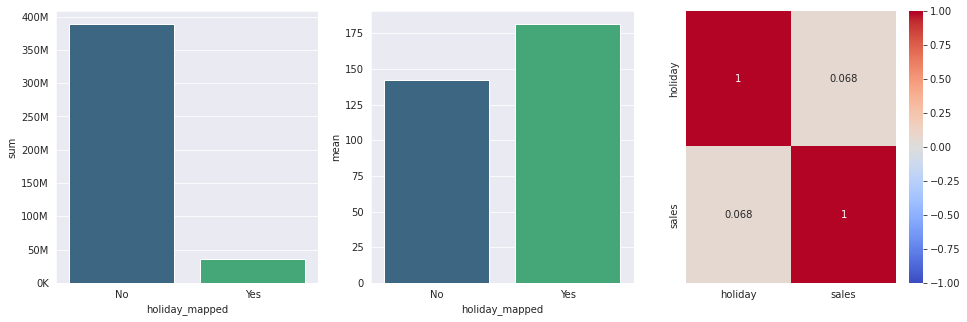

In [45]:
#@title Hypothesis 7 Plots

plt.figure(figsize=(16,5))

aux1 = df4[['holiday','sales']].groupby('holiday')['sales'].agg(['sum','mean']).reset_index()
aux1['holiday_mapped'] = aux1['holiday'].replace({0:'No',1:'Yes'})

plt.subplot(1,3,1)
g1 = sns.barplot(data=aux1, x='holiday_mapped', y='sum',palette='viridis')
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,3,2)
g2 = sns.barplot(data=aux1, x='holiday_mapped', y='mean',palette='viridis')

plt.subplot(1,3,3)
g3 = sns.heatmap(df4[['holiday','sales']].corr(),cmap='coolwarm',vmax=1,vmin=-1,annot=True)

### $H_{8}:$ Stores with more item variety should sell more
**TRUE** $\Rightarrow$ Total sales increases along with item variety

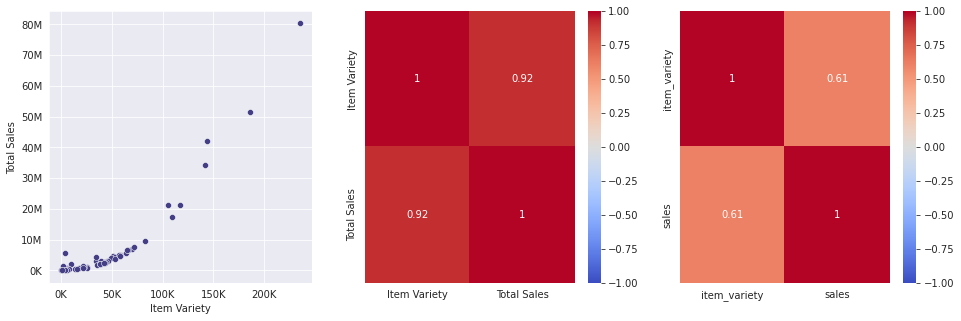

In [60]:
#@title Hypothesis 8 plots
plt.figure(figsize=(16,5))

aux1 = df4[['shop_name','item_name','sales']].groupby('shop_name').agg({'item_name':'count', 'sales': 'sum'}).reset_index().rename(columns={'item_name':'Item Variety','sales':'Total Sales'})

plt.subplot(1,3,1)
g1 = sns.scatterplot(data=aux1,x='Item Variety',y='Total Sales',color=viridis)
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))
g1.xaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,3,2)
sns.heatmap(aux1[['Item Variety','Total Sales']].corr(),vmin=-1,vmax=1,annot=True,cmap='coolwarm')

variety_dict = dict(zip(aux1['shop_name'], aux1['Item Variety']))
df4['item_variety'] = df4['shop_name'].map(variety_dict)
plt.subplot(1,3,3,)
sns.heatmap(df4[['item_variety','sales']].corr(),vmin=-1,vmax=1,annot=True,cmap='coolwarm')

plt.show()

### $H_{9}:$ Stores with higher range of prices should sell more
**FALSE** $\Rightarrow$ Stores with higher range of prices DON'T SELL MORE

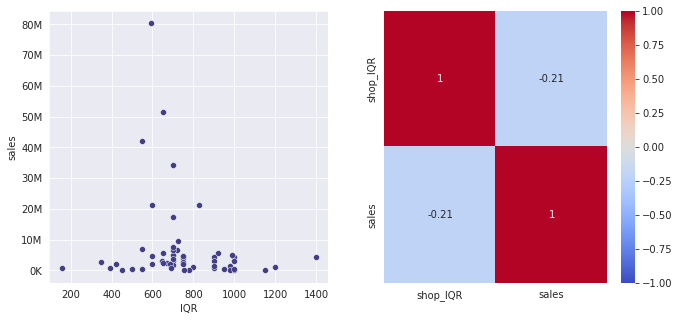

In [61]:
#@title Hypothesis 9 plots
plt.figure(figsize=(11,5))

aux1 = df4[['shop_name','item_price']].groupby('shop_name').quantile(0.75).reset_index()
aux2 = df4[['shop_name','item_price']].groupby('shop_name').quantile(0.25).reset_index()
aux1['IQR'] = aux1['item_price'] - aux2['item_price']
aux3 = df4[['shop_name','sales']].groupby('shop_name').agg({'sales':'sum'}).reset_index()
aux1 = pd.concat([aux1,aux3['sales']],axis=1)

plt.subplot(1,2,1)
g1 = sns.scatterplot(data=aux1,x='IQR',y='sales',color=viridis)
g1.yaxis.set_major_formatter(tick.FuncFormatter(format_number))

plt.subplot(1,2,2)
price_dict = dict(zip(aux1['shop_name'], aux1['IQR']))
df4['shop_IQR'] = df4['shop_name'].map(price_dict)
sns.heatmap(df4[['shop_IQR','sales']].corr(),vmin=-1,vmax=1,annot=True,cmap='coolwarm')

plt.show()

### 4.2.1. Summary of Hypothesis

In [62]:
#@title Relevance of the Conclusions of Hypothesis
tab = [['Hypothesis','Conclusion','Relevance'],
       ['H1','False','High'],
       ['H2','False','Low'],
       ['H3','False','Low'],
       ['H4','True','High'],
       ['H5','True','Medium'],
       ['H6','False','Medium'],
       ['H7','False','Low'],
       ['H8','True','High'],
       ['H9','False','Low']]
print(tabulate(tab,headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         High
H2            False         Low
H3            False         Low
H4            True          High
H5            True          Medium
H6            False         Medium
H7            False         Low
H8            True          High
H9            False         Low


## 4.3. Multivariate Analysis


### 4.3.1. Numerical Attributes

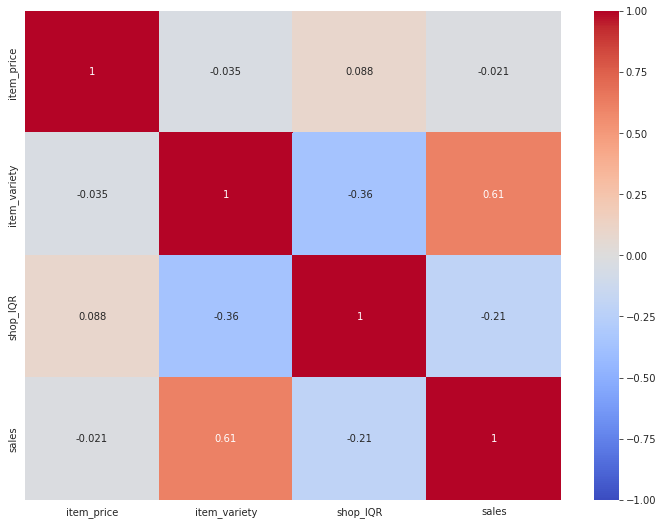

In [63]:
plt.figure(figsize=(12,9))
correlation = df4[['item_price','item_variety','shop_IQR','sales']].corr(method='pearson')
sns.heatmap(correlation,annot=True,cmap='coolwarm',vmin=-1, vmax=1)
plt.show()

### 4.3.2. Categorical Attributes

In [64]:
a = df4.select_dtypes(include=object)

a1 = cramer_v(a['shop_name'],a['shop_name'])
a2 = cramer_v(a['shop_name'],a['city'])
a3 = cramer_v(a['shop_name'],a['shop_type'])

a4 = cramer_v(a['city'],a['shop_name'])
a5 = cramer_v(a['city'],a['city'])
a6 = cramer_v(a['city'],a['shop_type'])

a7 = cramer_v(a['shop_type'],a['shop_name'])
a8 = cramer_v(a['shop_type'],a['city'])
a9 = cramer_v(a['shop_type'],a['shop_type'])

correlation2 = pd.DataFrame( {'shop_name': [a1,a2,a3],
                              'city': [a4,a5,a6],
                              'shop_type': [a7,a8,a9]})

correlation2 = correlation2.set_index(correlation2.columns)

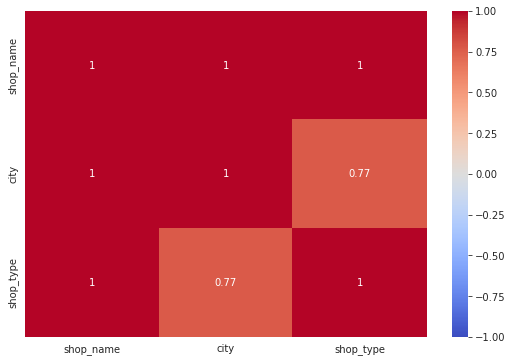

In [65]:
plt.figure(figsize=(9,6))
sns.heatmap(correlation2,annot=True,cmap='coolwarm',vmin=-1, vmax=1)
plt.show()

# 5. Data Preparation

In [73]:
df5 = df4.copy()

## 5.1. Normalization

### No Gaussian Distributions were found
- Because of this, we won't perform normalization on any of the variables;


## 5.2. Rescaling

### 5.2.1. Year

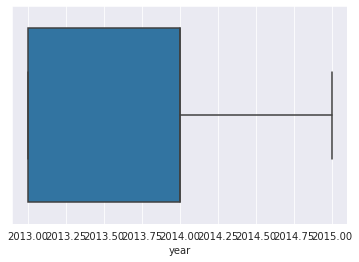

In [67]:
#@title Boxplot of Year
sns.boxplot(df5['year'])
plt.show()

In [68]:
mms = MinMaxScaler()
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3. Data Transformation

### 5.3.1. Encoding

In [69]:
df5.dtypes

date                  datetime64[ns]
item_price                   float64
item_name                     object
item_category_name            object
shop_name                     object
simple_categories             object
city                          object
shop_type                     object
year                         float64
month                          int64
day                            int64
week_of_year                   int64
year_week                     object
day_of_week                    int64
week_tl                        int64
sales                        float64
holiday                        int64
none                           int64
item_variety                   int64
shop_IQR                     float64
dtype: object

In [70]:
df5[['shop_name','city','shop_type','item_variety','shop_IQR']].nunique()

shop_name       60
city            30
shop_type        8
item_variety    60
shop_IQR        37
dtype: int64

In [77]:
# shop_name - Label Encoding
le = LabelEncoder()
df5['shop_name'] = le.fit_transform(df5['shop_name'])

# city - Label Encoding
df5['city'] = le.fit_transform(df5['city'])

# shop_type - One Hot Encoding
df5 = pd.get_dummies(df5,prefix=['shop_type'],columns=['shop_type'])

# item_variety - Ordinal Encoding
variety_dict = dict(zip(df5['item_variety'].sort_values(),list(range(60))))
df5['item_variety'] = df5['item_variety'].map(variety_dict)

# shop_IQR - Ordinal Encoding
iqr_dict = dict(zip(df5['shop_IQR'].sort_values(),list(range(37))))
df5['shop_IQR'] = df5['shop_IQR'].map(iqr_dict)

### 5.3.2. Response Variable Transformation

In [78]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [79]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. * np.pi/52)))

# day of the week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. * np.pi/7)))

# 6. Feature Selection

In [80]:
df6 = df5.copy()

In [82]:
df6.columns.tolist()

['date',
 'item_price',
 'item_name',
 'item_category_name',
 'shop_name',
 'simple_categories',
 'city',
 'year',
 'month',
 'day',
 'week_of_year',
 'year_week',
 'day_of_week',
 'week_tl',
 'sales',
 'holiday',
 'none',
 'item_variety',
 'shop_IQR',
 'shop_type_Digital',
 'shop_type_None',
 'shop_type_Shopping Center',
 'shop_type_TC',
 'shop_type_TK',
 'shop_type_TPC',
 'shop_type_TRC',
 'shop_type_TRK',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [84]:
cols_drop = ['date','item_price',
             'item_name',
             'item_category_name',
             'simple_categories',
             'month',
             'day',
             'week_of_year',
             'year_week',
             'day_of_week',
#             'week_tl',
             'holiday']
df6 = df6.drop(cols_drop,axis=1)

## 6.1. Training and Test Dataset Split